# VAE Training

In machine learning, a variational autoencoder,also known as VAE, is the artificial neural network.Variational autoencoders are meant to compress the input information into a constrained multivariate latent distribution (encoding) to reconstruct it as accurately as possible (decoding). Although this type of model was initially designed for unsupervised learning,its effectiveness has been proven in other domains of machine learning such as semi-supervised learning or supervised learning.

The **encoder** is a neural network. Its input is a datapoint **x**, its output is a hidden representation **z**, and it has weights and biases **θ**. To be concrete, let’s say **x** is a **28** by **28**-pixel photo of a handwritten number. The encoder ‘encodes’ the data which is **784**-dimensional into a latent (hidden) representation space **z**, which is much less than **784** dimensions. This is typically referred to as a ‘bottleneck’ because the encoder must learn an efficient compression of the data into this lower-dimensional space. Let’s denote the encoder **qθ(z|x)**. We note that the lower-dimensional space is stochastic: the encoder outputs parameters to **qθ(z|x)**, which is a Gaussian probability density. We can sample from this distribution to get noisy values of the representations z.

The **decoder** is another neural net. Its input is the representation **z**, it outputs the parameters to the probability distribution of the data, and has weights and biases **ϕ**. The decoder is denoted by **Pϕ(x|z)**. Running with the handwritten digit example, let’s say the photos are black and white and represent each pixel as **0** or **1**. The probability distribution of a single pixel can be then represented using a Bernoulli distribution. The decoder gets as input the latent representation of a digit **z** and outputs **784** Bernoulli parameters, one for each of the **784** pixels in the image. The decoder ‘decodes’ the real-valued numbers in **z** into **784** real-valued numbers between **0** and **1**. Information from the original **784**-dimensional vector cannot be perfectly transmitted, because the decoder only has access to a summary of the information (in the form of a less-than-**784**-dimensional vector **z**). How much information is lost? We measure this using the reconstruction log-likelihood **logPϕ(x|z)** whose units are nats. This measure tells us how effectively the decoder has learned to reconstruct an input image **x** given its latent representation **z**.

The loss function of the variational autoencoder is the negative log-likelihood with a regularizer. Because there are no global representations that are shared by all datapoints, we can decompose the loss function into only terms that depend on a single datapoint **l<sub>i</sub>** The total loss is then **∑<sub>i=1</sub><sup>N</sup>** for **N** total datapoints. The loss function for **l<sub>i</sub>** datapoint **x<sub>i</sub>** is: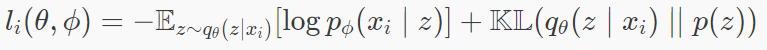

The first term is the reconstruction loss, or expected negative log-likelihood of the i-th datapoint. The expectation is taken with respect to the encoder’s distribution over the representations. This term encourages the decoder to learn to reconstruct the data. If the decoder’s output does not reconstruct the data well, statistically we say that the decoder parameterizes a likelihood distribution that does not place much probability mass on the true data. For example, if our goal is to model black and white images and our model places high probability on there being black spots where there are actually white spots, this will yield the worst possible reconstruction. Poor reconstruction will incur a large cost in this loss function.

The second term is a regularizer that we throw in (we’ll see how it’s derived later). This is the Kullback-Leibler divergence between the encoder’s distribution **qθ(z|x)** and **p(z)**. This divergence measures how much information is lost (in units of nats) when using **q** to represent **p**. It is one measure of how close **q** is to **p**.

In the variational autoencoder, p is specified as a standard Normal distribution with mean zero and variance one, or **p(z) = Normal(0,1)**. If the encoder outputs representations **z** that are different than those from a standard normal distribution, it will receive a penalty in the loss. This regularizer term means ‘keep the representations **z** of each digit sufficiently diverse’. If we didn’t include the regularizer, the encoder could learn to cheat and give each datapoint a representation in a different region of Euclidean space. This is bad, because then two images of the same number (say a 2 written by different people, **2<sub>alice</sub>** and  **2<sub>bob</sub>** ) could end up with very different representations **Z<sub>alice</sub>** , **Z<sub>bob</sub>**  . We want the representation space of z to be meaningful, so we penalize this behavior. This has the effect of keeping similar numbers’ representations close together (e.g. so the representations of the digit two **Z<sub>alice</sub>** , **Z<sub>bob</sub>** , **Z<sub>ali</sub>** remain sufficiently close).

We train the variational autoencoder using gradient descent to optimize the loss with respect to the parameters of the encoder and decoder **θ** and **ϕ**. For stochastic gradient descent with step size ρ, the encoder parameters are updated using **θ←θ−ρ<sup>∂θ</sup>/<sub>∂l</sub>** and the decoder is updated similarly.


 ### Kullback–Leibler (KL) divergence
 
KL divergence is a way of measuring how much one probability distribution differs from another. In a VAE, we want to measure how different our normal distribution with parameters mu and log_var is from the standard normal distribution. In this special case, the KL divergence has the closed form:
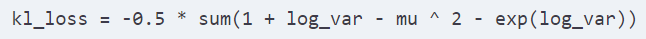

or in mathematical notation:
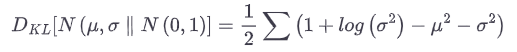

The sum is taken over all the dimensions in the latent space. kl_loss is minimized to 0 when mu = 0 and log_var = 0 for all dimensions. As these two terms start to differ from 0, kl_loss increases.

In summary, the KL divergence term penalizes the network for encoding observations to mu and log_var variables that differ significantly from the parameters of a standard normal distribution, namely mu = 0 and log_var = 0.

Again, relating this back to our story, this term represents Epsilon’s annoyance at having to move the ladder away from the middle of the wall (mu different from 0) and also if Mr. N. Coder’s confidence in the marker position isn’t just right (log_var different from 0), both of which incur a cost.

In the code, the loss function for a VAE is simply the addition of the reconstruction loss and the KL divergence loss term. We weight the reconstruction loss with a term, r_loss_factor, that ensures that it is well balanced with the KL divergence loss. If we weight the reconstruction loss too heavily, the KL loss will not have the desired regulatory effect and we will see the same problems that we experienced with the plain autoencoder. If the weighting term is too small, the KL divergence loss will dominate and the reconstructed images will be poor. This weighting term is one of the parameters to tune when you’re training your VAE.

### Intuitions about the regularisation
The regularity that is expected from the latent space in order to make generative process possible can be expressed through two main properties: continuity (two close points in the latent space should not give two completely different contents once decoded) and completeness (for a chosen distribution, a point sampled from the latent space should give “meaningful” content once decoded).
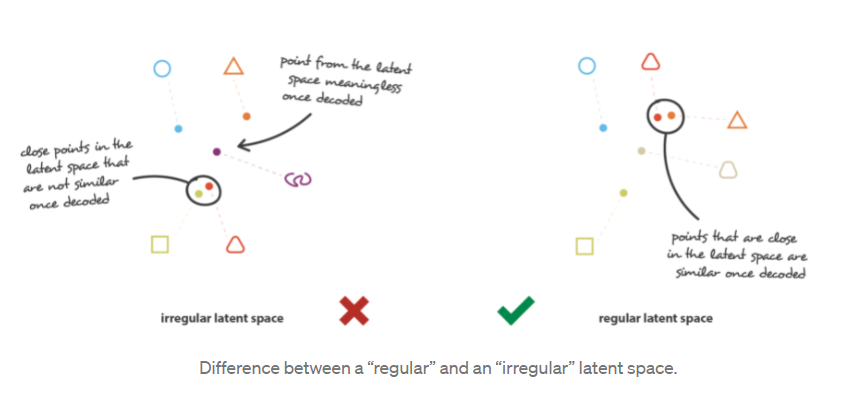

## imports

In [ ]:
import os

from models.VAE import VariationalAutoencoder
from utils.loaders import load_mnist

In [2]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

## data

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

## architecture

In [ ]:
#in the VAE.py
#Instead of connecting the flattened layer directly to the 2D latent space, we connect it to layers mu and log_var
#The Keras model that outputs the values of mu and log_var for a given input image.
#Lambda layer samples a point z in the latent space from the normal distribution defined by the parameters mu and log_var
#The Keras model that defines the encoder—a model that takes an input image and encodes it into the 2D latent space,
#by sampling a point from the normal distribution defined by mu and log_var
vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [5]:
vae.encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [6]:
vae.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

## training

In [7]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

In [ ]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [9]:
BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [10]:
vae.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

W1120 21:19:48.705870 34904 deprecation_wrapper.py:119] From D:\anaconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/200
60000/60000 [==============================] - 99s 2ms/step - loss: 58.5893 - vae_r_loss: 55.3527 - vae_kl_loss: 3.2366

Epoch 00001: saving model to run/vae/0002_digits\weights/weights-001-58.59.h5

Epoch 00001: saving model to run/vae/0002_digits\weights/weights.h5
Epoch 2/200
60000/60000 [==============================] - 97s 2ms/step - loss: 51.6628 - vae_r_loss: 47.6434 - vae_kl_loss: 4.0194

Epoch 00002: saving model to run/vae/0002_digits\weights/weights-002-51.66.h5

Epoch 00002: saving model to run/vae/0002_digits\weights/weights.h5
Epoch 3/200
60000/60000 [==============================] - 98s 2ms/step - loss: 49.9338 - vae_r_loss: 45.5642 - vae_kl_loss: 4.3696

Epoch 00003: saving model to run/vae/0002_digits\weights/weights-003-49.93.h5

Epoch 00003: saving model to run/vae/0002_digits\weights/weights.h5
Epoch 4/200
60000/60000 [==============================] - 99s 2ms/step - loss: 49.0042 - vae_r_loss: 44.4690 - vae_kl_loss: 4.5352

Epoch 00004: saving model t

KeyboardInterrupt: 